In [1]:
import pandas as pd
from pathlib import Path
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
import graphs

# Wczytanie danych
json_file = Path("../data/clean_data.json")
df = pd.read_json(json_file, orient='records', lines=True)

# Zachowanie kolumny `url` do późniejszego powiązania
urls = df["url"]

# Przygotowanie danych do treningu
df = df.drop(columns=["id", "lokalizacja", "url"], errors="ignore")
X = df.drop(columns=["cena"])  # Wszystkie kolumny poza 'cena' jako cechy
X = pd.get_dummies(X, columns=["model", "rodzaj_paliwa", "skrzynia_biegow", "naped", "typ_nadwozia", "kolor", "stan_pojazdu"], drop_first=True)
X[['rok_produkcji', 'przebieg', 'pojemnosc_silnika', 'moc_silnika', 'liczba_drzwi', 'liczba_miejsc']] = StandardScaler().fit_transform(X[['rok_produkcji', 'przebieg', 'pojemnosc_silnika', 'moc_silnika', 'liczba_drzwi', 'liczba_miejsc']])
y = df["cena"]  # Kolumna 'cena' jako cel

# Podział na zbiory treningowe i testowe
X_train, X_test, y_train, y_test, urls_train, urls_test = train_test_split(X, y, urls, test_size=0.2, random_state=42)


c:\studia\wejherowo_tree\wejherowo\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ścieżka do pliku modelu
model_file = Path("../models/final_model_xgboost.pkl")

# Wczytanie modelu
if model_file.exists():
    loaded_model = joblib.load(model_file)
    print(f"Model wczytany z pliku: {model_file}")
else:
    raise FileNotFoundError(f"Plik {model_file} nie istnieje.")

# Predykcja na zbiorze testowym
y_test_pred = loaded_model.predict(X_test)

# Obliczenie metryk
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_percentage_error = ((abs(y_test - y_test_pred) / y_test) * 100).mean()

# Wyświetlenie wyników
print("Ewaluacja modelu na zbiorze testowym:")
print(f"RMSE: {test_rmse:.2f} PLN")
print(f"Średni błąd w PLN (MAE): {test_mae:.2f} PLN")
print(f"Średnia procentowa rozbieżność: {test_percentage_error:.2f}%")


Model wczytany z pliku: ..\models\final_model_xgboost.pkl
Ewaluacja modelu na zbiorze testowym:
RMSE: 23207.38 PLN
Średni błąd w PLN (MAE): 12578.83 PLN
Średnia procentowa rozbieżność: 14.74%


c:\studia\wejherowo_tree\wejherowo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [3]:
from utils import save_to_json

save_to_json(y_test_pred, y_test, urls_test, path="../data/interactive_data.json")

Dane zostały zapisane do ..\data\interactive_data.json


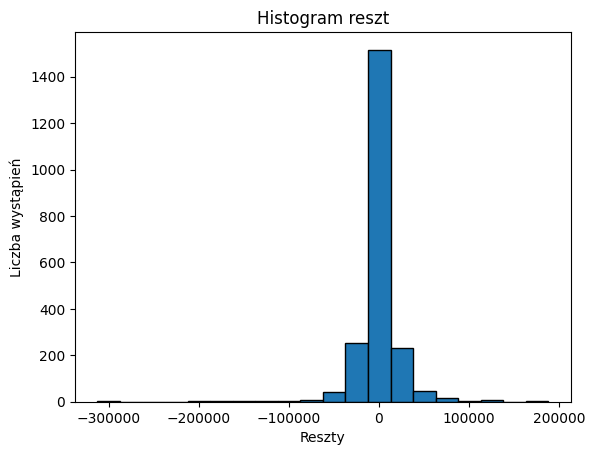

In [4]:
graphs.residuals_hist(y_test_pred, y_test)

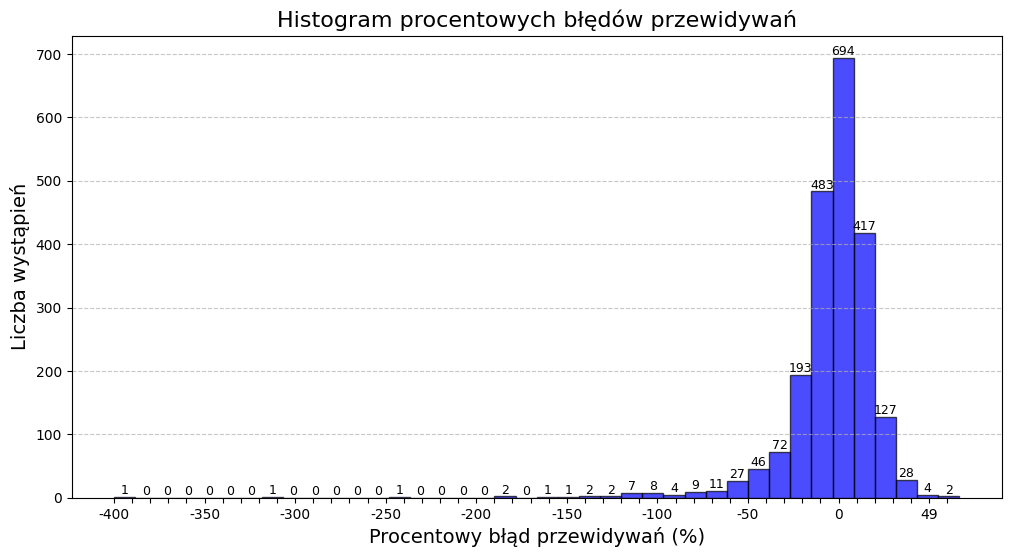

In [5]:
# Przykład użycia funkcji
graphs.plot_percentage_error_histogram(y_test_pred, y_test, 40)

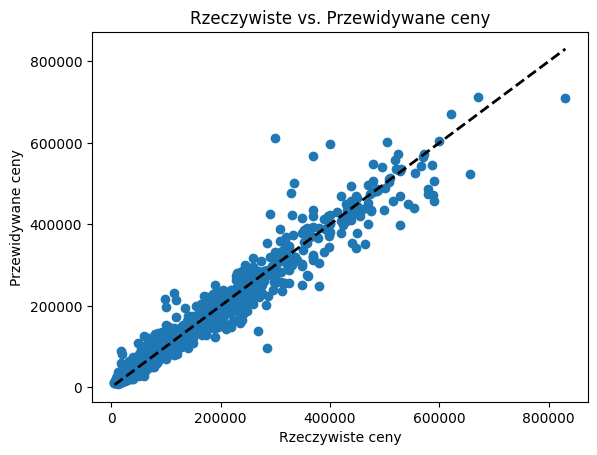

In [6]:
graphs.real_vs_predicted_prices(y_test_pred, y_test)

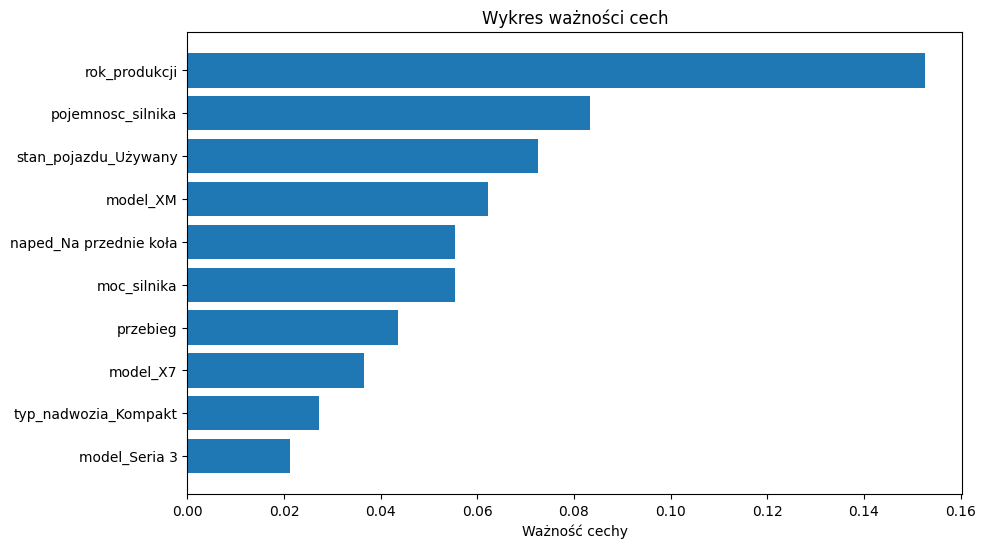

In [7]:
graphs.feature_importances(X, loaded_model)